## Load Libraries and Parameters:

### Libraries:

In [1]:
import sys
sys.path.append('core')
import hydromet_reduced
from hydromet import*

### Specify parameters: 
- Shared parameters needed for running the EventsTable.ipynb and the reEventsTable.ipynb.

In [2]:
## Filenames and paths:
AOI = 'Augusta'     # Area of interest
Model = 'P01'  # Model name
root_dir = pl.Path(os.getcwd())
outputs_dir = root_dir/'Outputs'
notebook_dir = root_dir/'Notebooks'


## Options:
seed = 3537 #np.random.randint(low=0, high=10000)
display_plots = True
display_print = True
distal = False #Indicates whether the notebook is being called from papermill via the distEventsTable.ipynb

---

## A. Run EventsTable Notebook:

### Specify parameters:

In [3]:
## Excess rainfall parameters:
CN = 76                    # Curve number
volume = 9                   # NOAA Atlas 14 volume
region = 2                   # NOAA Atlas 14 region
durations = [6, 12, 24, 96]  # Calculate multiple durations 
#durations = [6]            # Calcuate a single duration


## Grouping parameters:
tempEpsilon_dic = {'6': 1, '12': 2, '24': 4, '96': 16} 
tempEpsilon2_dic = {'6': 0.5, '12': 1, '24': 2, '96': 8}
convEpsilon_dic = {'6': 163.64, '12': 178.95, '24': 180.95, '96': 184.62}
volEpsilon_dic = convEpsilon_dic #{'6': 180.95, '12': 180.95, '24': 180.95, '96': 180.95} 


## Filenames and paths:
BCN = 'D01'    # Boundary condition name
precip_table = 'PrecipTable_{0}.xlsx'.format(AOI) 

inputs_dir = root_dir/'Inputs'
precip_table_dir = outputs_dir/precip_table
datarepository_dir = root_dir/'DataRepository'
bin_dir = root_dir/'bin'


## Options:
papermill = False 
save_dss = False
remove_ind_dur = True #Remove individual duration files which are combined at the end of this notebook

### Run:

In [4]:
print("Randomly selected seed: {0}".format(seed))

if not os.path.exists(notebook_dir): os.mkdir(notebook_dir)
    
nb_executed = {}

for dur in durations:
    nb_executed[str(dur)] = str(notebook_dir/'EventsTable_{0}_Dur{1}_tempE{2}_{3}_convE{4}_volE{5}.ipynb'.format(AOI, dur,
                                                                                                                 tempEpsilon_dic[str(dur)], 
                                                                                                                 tempEpsilon2_dic[str(dur)], 
                                                                                                                 convEpsilon_dic[str(dur)], 
                                                                                                                 volEpsilon_dic[str(dur)]))
    print( nb_executed[str(dur)])
    nb_parameters = {'CN': CN,
                     'volume': volume,
                     'region': region,
                     'duration': dur,
                     'tempEpsilon': tempEpsilon_dic[str(dur)],
                     'tempEpsilon2': tempEpsilon2_dic[str(dur)],
                     'convEpsilon': convEpsilon_dic[str(dur)],
                     'volEpsilon': volEpsilon_dic[str(dur)],
                     'AOI': AOI,
                     'precip_table_dir': str(precip_table_dir),
                     'datarepository_dir': str(datarepository_dir),
                     'bin_dir': str(bin_dir),
                     'outputs_dir': str(outputs_dir),
                     'seed': seed,
                     'papermill': papermill,
                     'display_plots': display_plots,
                     'display_print': display_print,
                     'save_dss': save_dss}
    
    pm.execute_notebook('EventsTable.ipynb', nb_executed[str(dur)], parameters = nb_parameters);
    
    nb = nb_executed[str(dur)]
    ! jupyter nbconvert $nb --log-level WARN

Randomly selected seed: 3537
C:\Users\sputnam\Documents\GitHub\pfra-hydromet\Notebooks\EventsTable_Augusta_Dur6_tempE1_0.5_convE163.64_volE163.64.ipynb


c:\users\sputnam\appdata\local\continuum\anaconda3\lib\site-packages\nbconvert\filters\datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['application/scrapbook.scrap.json+json']) is not able to be represented.
  mimetypes=output.keys())


C:\Users\sputnam\Documents\GitHub\pfra-hydromet\Notebooks\EventsTable_Augusta_Dur12_tempE2_1_convE178.95_volE178.95.ipynb


c:\users\sputnam\appdata\local\continuum\anaconda3\lib\site-packages\nbconvert\filters\datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['application/scrapbook.scrap.json+json']) is not able to be represented.
  mimetypes=output.keys())


C:\Users\sputnam\Documents\GitHub\pfra-hydromet\Notebooks\EventsTable_Augusta_Dur24_tempE4_2_convE180.95_volE180.95.ipynb


c:\users\sputnam\appdata\local\continuum\anaconda3\lib\site-packages\nbconvert\filters\datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['application/scrapbook.scrap.json+json']) is not able to be represented.
  mimetypes=output.keys())


C:\Users\sputnam\Documents\GitHub\pfra-hydromet\Notebooks\EventsTable_Augusta_Dur96_tempE16_8_convE184.62_volE184.62.ipynb


c:\users\sputnam\appdata\local\continuum\anaconda3\lib\site-packages\nbconvert\filters\datatypefilter.py:41: UserWarning: Your element with mimetype(s) dict_keys(['application/scrapbook.scrap.json+json']) is not able to be represented.
  mimetypes=output.keys())


### Display the results:

#### Open the executed notebook and extract the scraps:

In [5]:
final_reduction_dic = {}

for dur in durations:
    nb = sb.read_notebook(nb_executed[str(dur)])
    final_reduction_dic[str(dur)] = nb.scraps['final_reduction_lst'][1]

#### Final incremental excess rainfall results (combined events):

In [6]:
for dur in durations:
    print("Number of curves reduced by {0}% or {1} curves out of {2} remaining".format(np.round(final_reduction_dic[str(dur)][0], 2), final_reduction_dic[str(dur)][1], final_reduction_dic[str(dur)][2]))

Number of curves reduced by 95.98% or 200 curves out of 4969 remaining
Number of curves reduced by 95.59% or 220 curves out of 4988 remaining
Number of curves reduced by 95.03% or 246 curves out of 4951 remaining
Number of curves reduced by 95.05% or 248 curves out of 5015 remaining


### Combine the results for all durations and save:

#### Excess rainfall:

In [7]:
excess_dic = combine_results('Excess_Rainfall', outputs_dir, AOI, durations, tempEpsilon_dic, convEpsilon_dic, volEpsilon_dic, BCN, remove_ind_dur)

with open(outputs_dir/'{0}_{1}.json'.format(AOI, Model), 'w') as f:
    json.dump(excess_dic, f)

#### Event weights:

In [8]:
weights_dic = combine_results('Weights', outputs_dir, AOI, durations, tempEpsilon_dic, convEpsilon_dic, volEpsilon_dic, BCN, remove_ind_dur)

with open(outputs_dir/'Weights_{0}_{1}.json'.format(AOI, Model), 'w') as f:
    json.dump(weights_dic, f)

Total Weight: 0.5


#### Metadata:

In [9]:
metadata = combine_metadata(outputs_dir, AOI, durations, tempEpsilon_dic, convEpsilon_dic, volEpsilon_dic, BCN, remove_ind_dur)

with open(outputs_dir/'Metadata_{0}_{1}.json'.format(AOI, Model), 'w') as f:
    json.dump(metadata, f)       

### QC the combined results:

#### Plot the weight versus the total runoff for each group

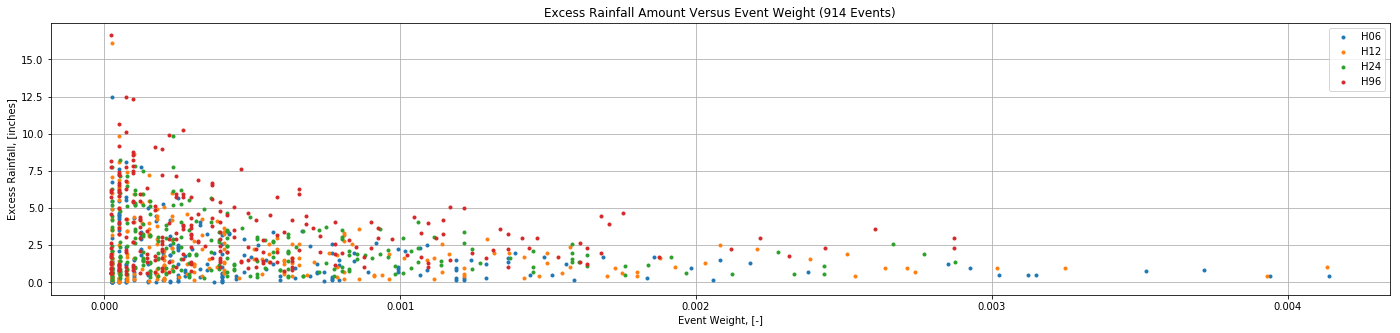

In [10]:
plot_amount_vs_weight(weights_dic, excess_dic, BCN)

---

## B. Run ReducedEvents Notebook:

### Specify parameters:

#### The stormwater removal rate and capacity:

In [11]:
rate = 0.0459    # [L^3/30min]
maxcap = 2.2032  # [L^3]

rand_rate_cap = False # DO NOT MODIFY

#### Or the minimum and maxium stormwater removal rates, which are used to randomly select the removal rate and capacity:

### Run:

In [29]:
reEventsTable = str(notebook_dir/'reEventsTable_{0}_{1}.ipynb'.format(AOI, Model))
                                                                                                                 
if rand_rate_cap:
    nb_parameters = {'minrate': minrate, 'maxrate': maxrate, 'AOI': AOI, 'Model': Model, 'outputs_dir': str(outputs_dir), 
                     'seed': seed, 'rand_rate_cap': rand_rate_cap, 'display_plots': display_plots, 'display_print': display_print, 'distal': distal}
else:
    nb_parameters = {'rate': rate, 'maxcap': maxcap, 'AOI': AOI, 'Model': Model, 'outputs_dir': str(outputs_dir), 
                     'rand_rate_cap': rand_rate_cap, 'display_plots': display_plots, 'display_print': display_print, 'distal': distal}
    
    
pm.execute_notebook('reEventsTable.ipynb', reEventsTable, parameters = nb_parameters);
    
! jupyter nbconvert $reEventsTable --log-level WARN

---

## Save a Copy of this Notebook:

### File save this notebook and then run:

In [30]:
orig_nb = 'PM-EventsTable'
new_nb = '{0}_{1}_{2}.ipynb'.format(orig_nb, AOI, Model)
new_nb_path = str(notebook_dir/new_nb)

shutil.copy(root_dir/'{0}.ipynb'.format(orig_nb), new_nb_path)

! jupyter nbconvert $new_nb_path --log-level WARN

## End